# Lab 5: More bandits, also curiosity

## Initialize Notebook

In [ ]:
# Install explorationlib?
!pip install --upgrade git+https://github.com/clappm/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/clappm/explorationlib to /tmp/pip-req-build-ck5b2o9b
  Running command git clone -q https://github.com/clappm/explorationlib /tmp/pip-req-build-ck5b2o9b
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=24685 sha256=609106be1bdfd38c5cc27907927b9d00579abad355f296e40329fa07abe95db7
  Stored in directory: /tmp/pip-ephem-wheel-cache-cdhzngwj/wheels/1e/34/cb/ead05d92d76276256463c4482648a973515fea65dd8c73b911
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-164079vu
  Running command git clone -q https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-164079vu
     |████████████████████████████████| 18.3 MB 1.3 MB/s 
  Created wheel for gym-maze: filename=gym_maze-0.4-py3-none-any.whl size=14241 sha256=5df95ea54bd9bb748a6bd12a82c4eff0b06090d27a8e469a640197df2c07dbac
  Stored in directory: /tmp/pip-ephem-wheel-cache-scfiszhz/wheels/01/f8/86/0dd8c448e192abff02b2a

In [77]:
# import basic modules
import shutil
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import explorationlib
import explorationlib

# import the type of environment we will be using
from explorationlib.local_gym import BanditUniform4
from explorationlib.local_gym import BanditUniform10
from explorationlib.local_gym import DeceptiveBanditOneHigh10

# import the components to build our agents
from explorationlib.agent import BanditActorCritic

from explorationlib.agent import Critic
from explorationlib.agent import CriticUCB
from explorationlib.agent import CriticNovelty

from explorationlib.agent import EpsilonActor
from explorationlib.agent import DeterministicActor
#from explorationlib.agent import RandomActor
#from explorationlib.agent import SequentialActor
from explorationlib.agent import BoundedRandomActor
from explorationlib.agent import BoundedSequentialActor
from explorationlib.agent import SoftmaxActor

# import the experimental framework
from explorationlib.run import experiment

# import some scoring functions
from explorationlib.score import total_reward
from explorationlib.score import action_entropy

# import some utility functions
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# import some plotting functions
from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist

In [ ]:

# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Reviewing the basic (Q-value) critic

Recall the Q-value formula.  The "critic" is responsible for estimating the value of each arm, and the most basic critic simply returns the current Q value as the estimate.

image.png

In [ ]:
# don't run this cell

class Critic(BanditAgent):
    """Template for a Critic agent"""
    def __init__(self, num_inputs, default_value=0.0):
        super().__init__()

        self.num_inputs = num_inputs
        self.default_value = default_value

        self.model = OrderedDict()
        for n in range(self.num_inputs):
            self.model[n] = self.default_value

    def __call__(self, state):
        return self.forward(state)

    def forward(self, state):
        return self.model[state]

    def update(self, state, update):
        self.model[state] += update

    def replace(self, state, update):
        self.model[state] = update

    def state_dict(self):
        return self.model

    def load_state_dict(self, state_dict):
        self.model = state_dict

    def reset(self):
        self.model = OrderedDict()
        for n in range(self.num_inputs):
            self.model[n] = self.default_value

## Introducing the UCB Critic

The UCB critic add an additional exploratory bonus to the Q-values.  It essentially tries to estimate how rewarding each arm *could* be, so there is now an incentive to favor arms for which there is high uncertainty.

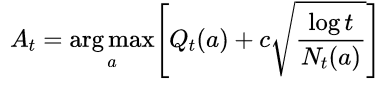

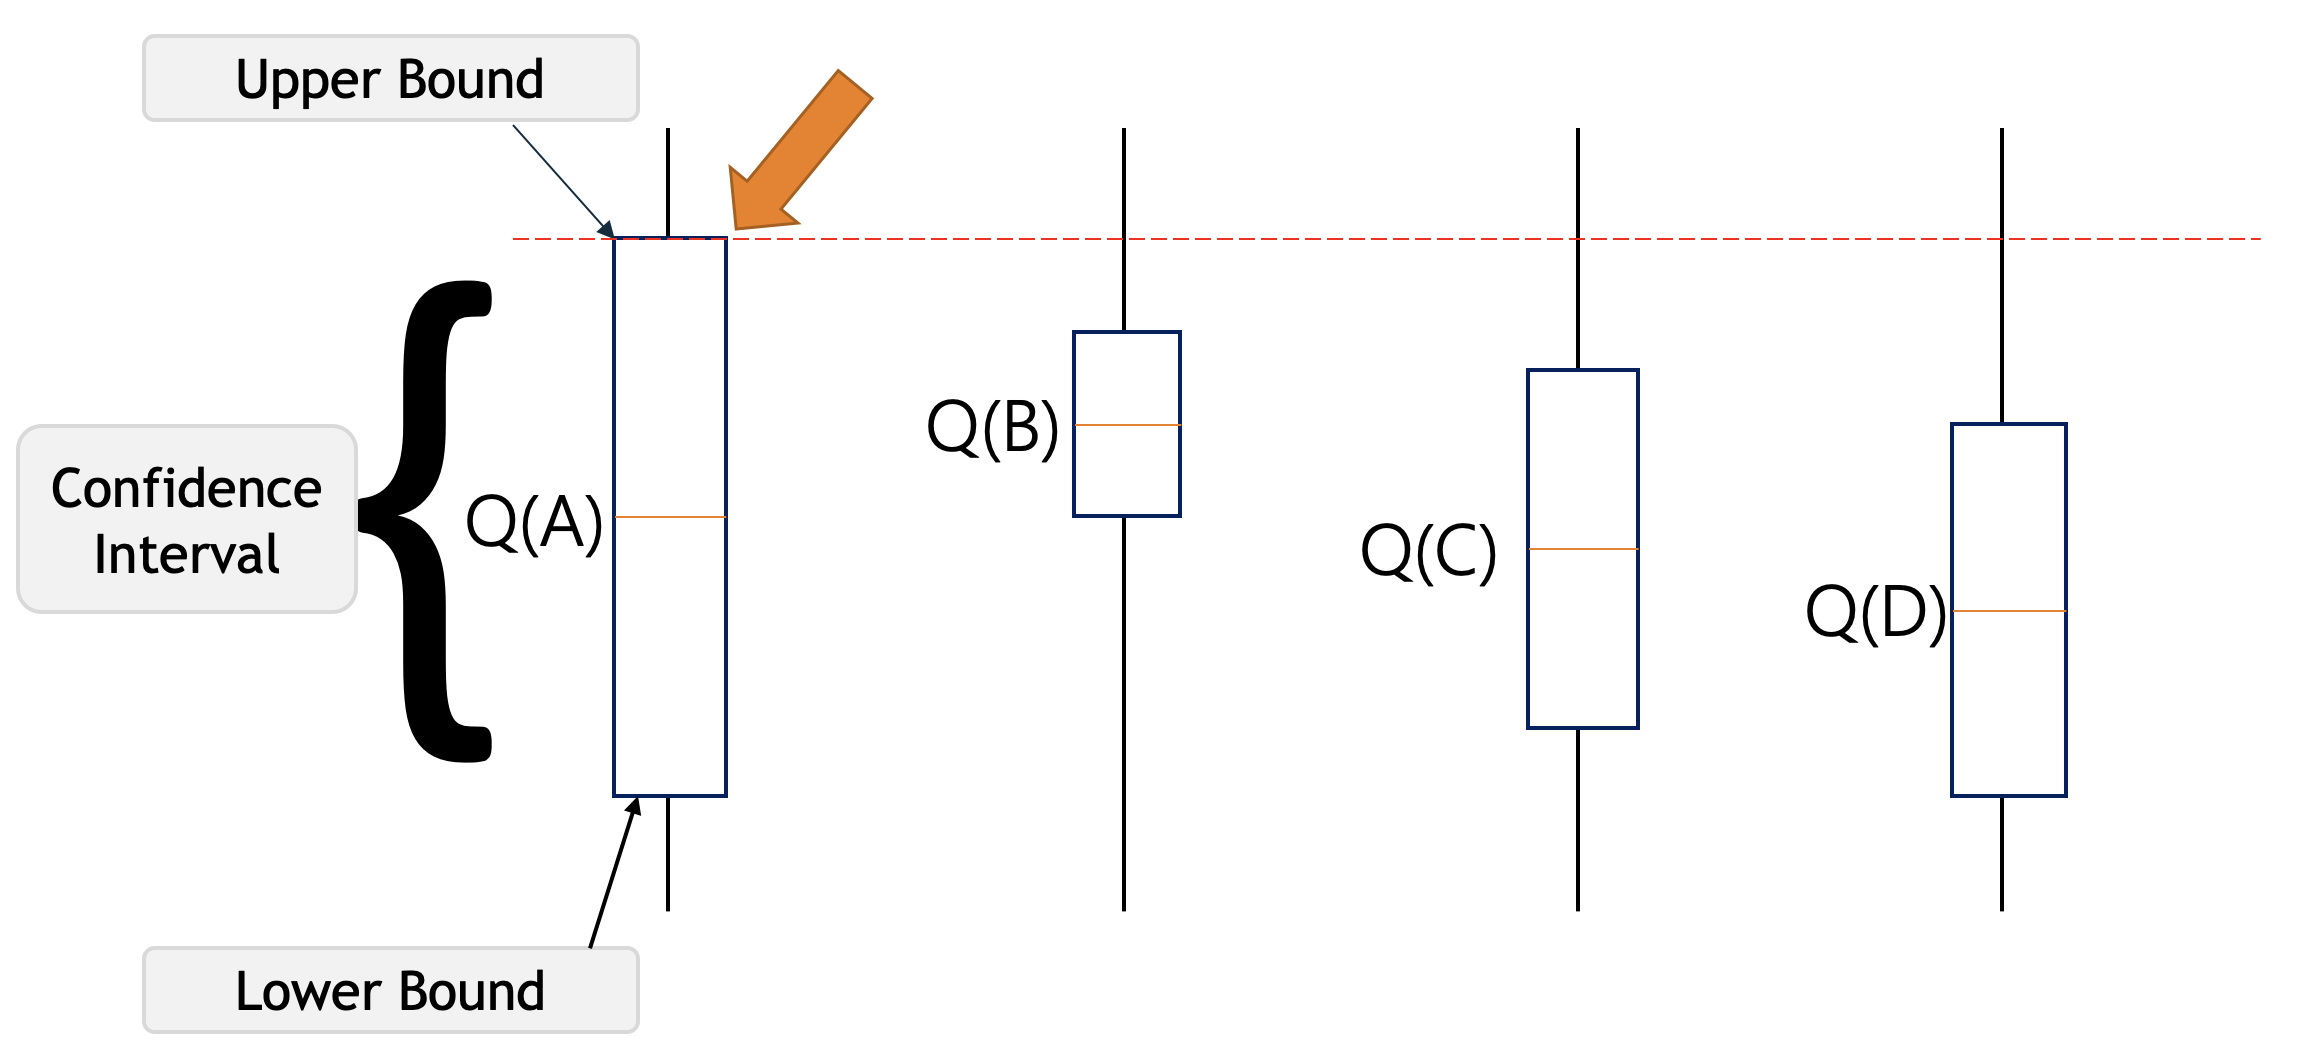

In [ ]:
# don't run this cell

class CriticUCB(Critic):
    """Critic with a UCB bonus"""
    def __init__(self, num_inputs, default_value=0.0, bonus_weight=1.0):
        # Init base
        super().__init__(num_inputs, default_value)
        self.bonus_weight = float(bonus_weight)

        # Init UCB
        self.reset()

    def forward(self, state):
        # UCB bonus
        bonus = ((2 * np.log(self.n + 1)) / self.memory(state))**(0.5)
        bonus *= self.bonus_weight  # Scale

        # Value est.
        value = self.model[state] + bonus

        # Step global count
        self.n += 1

        # !
        # print(state, self.model[state], bonus)
        return value

    def reset(self):
        self.memory = CountMemory()
        self.n = 0

## Introducing the Novelty Bonus Critic

The novelty bonus is simple: you receive an intrinsic bonus for selecting any action you have not selected before.

In [ ]:
# don't run this cell

class CriticNovelty(Critic):
    """Critic with a novelty bonus"""
    def __init__(self,
                 num_inputs,
                 default_value=0.0,
                 novelty_bonus=1.0,
                 bonus_weight=1.0):
        # Init base
        super().__init__(num_inputs, default_value)

        # Init novelty (value of 1)
        self.novelty_bonus = float(novelty_bonus)
        self.bonus_weight = float(bonus_weight)
        self.reset()

    def forward(self, state):
        # Novelty
        bonus = self.memory(state)
        bonus *= self.bonus_weight  # Scale
        value = self.model[state] + bonus

        return value

    def reset(self):
        self.memory = NoveltyMemory(bonus=self.novelty_bonus)

## Introducing the Softmax (Boltzmann) Actor

The Softmax actor is an alternative to the Epsilon-Greedy actor.  

Recall that the Epsilon-Greedy actor, during each selection, is either purely exploitative (with probability 1-epsilon) or purely explorative (with probability epsilon).  The Softmax actor represents a different way of "limiting" our exploitation, by adjusting the probability of selecting each arm according to their relative values.

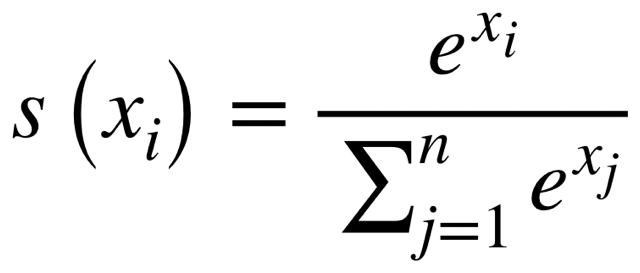

In [ ]:
# don't run this cell

class SoftmaxActor(BanditAgent):
    """Softmax actions"""
    def __init__(self, num_actions, actions=None, beta=1.0):
        super().__init__()

        self.beta = float(beta)
        self.num_actions = num_actions
        if actions is None:
            self.actions = list(range(self.num_actions))
            self.action_idx = deepcopy(self.actions)
        else:
            self.actions = actions
            self.action_idx = list(range(self.num_actions))

    def __call__(self, values):
        return self.forward(values)

    def forward(self, values):
        values = np.asarray(values)
        probs = softmax(values * self.beta)
        idx = self.np_random.choice(self.action_idx, p=probs)
        return self.actions[idx]

    def reset(self):
        pass

## Creating Our Environment and Agents

We are going to first run a demonstration of these agents with a basic 4-arm bandit task:

- purely exploitative agent (actor: deterministic, critic: q values only)
- UCB agent (actor: deterministic, critic: UCB)
- Novelty agent (actor: deterministic, critic: Novelty)
- Epsilon-greedy agent (actor: epsilon = 0.2, critic: q values only)
- Softmax agent (actor: softmax with beta = 1, critic: q values only)

Here's our environment:

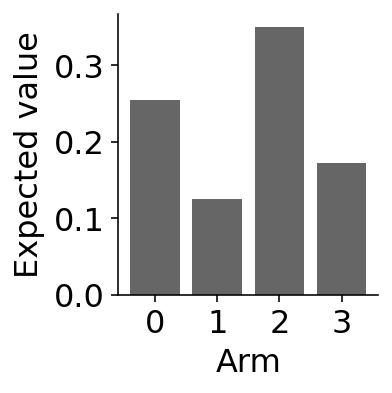

In [39]:
# Shared env params
seed = 503

# Create env
env = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.35)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

Now we make the agents:

In [46]:
exploit = BanditActorCritic(
    DeterministicActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
ucb = BanditActorCritic(
    DeterministicActor(num_actions=env.num_arms),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)
novelty = BanditActorCritic(
    DeterministicActor(num_actions=env.num_arms),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
egreedy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.2),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
softmax = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=1.0),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [exploit, ucb, novelty, egreedy, softmax]
names = ["exploit", "ucb", "novelty", "epsilon", "softmax"]
colors = ["blue", "green", "purple", "red", "orange", "yellow"]

In [47]:
num_steps = 400
num_experiments = 400

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

exploit:   0%|          | 0/400 [00:00<?, ?it/s]

ucb:   0%|          | 0/400 [00:00<?, ?it/s]

novelty:   0%|          | 0/400 [00:00<?, ?it/s]

epsilon:   0%|          | 0/400 [00:00<?, ?it/s]

softmax:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

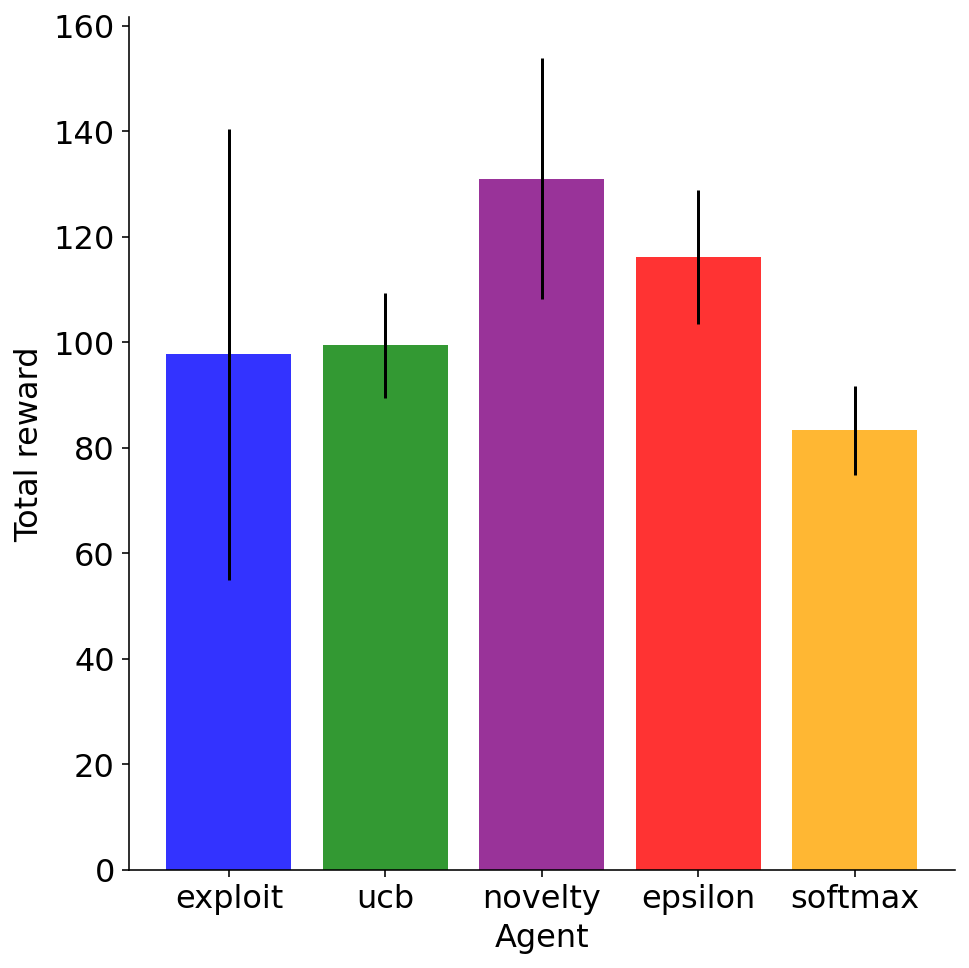

In [48]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

## Introducing more arms

We've spent all this time on 4-arm bandits, but what about bandits with more arms?  Here's a bandit with 10 arms, with will also serve as a comparison for a later section of the lab.

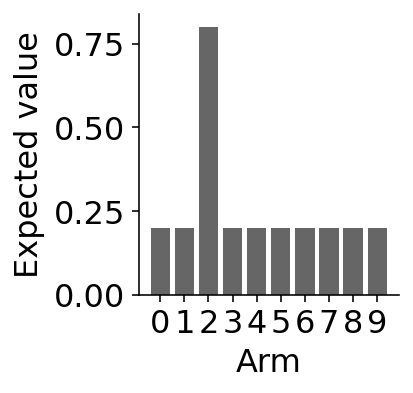

In [80]:
# Shared env params
seed = 503

# Create env
env = BanditUniform10(p_min=0.2, p_max=0.2, p_best=0.8)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

In [81]:
exploit = BanditActorCritic(
    DeterministicActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
ucb = BanditActorCritic(
    DeterministicActor(num_actions=env.num_arms),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)
novelty = BanditActorCritic(
    DeterministicActor(num_actions=env.num_arms),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
egreedy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.2),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
softmax = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=1.0),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [exploit, ucb, novelty, egreedy, softmax]
names = ["exploit", "ucb", "novelty", "epsilon", "softmax"]
colors = ["blue", "green", "purple", "red", "orange", "yellow"]

In [82]:
num_steps = 400
num_experiments = 400

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

exploit:   0%|          | 0/400 [00:00<?, ?it/s]

ucb:   0%|          | 0/400 [00:00<?, ?it/s]

novelty:   0%|          | 0/400 [00:00<?, ?it/s]

epsilon:   0%|          | 0/400 [00:00<?, ?it/s]

softmax:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

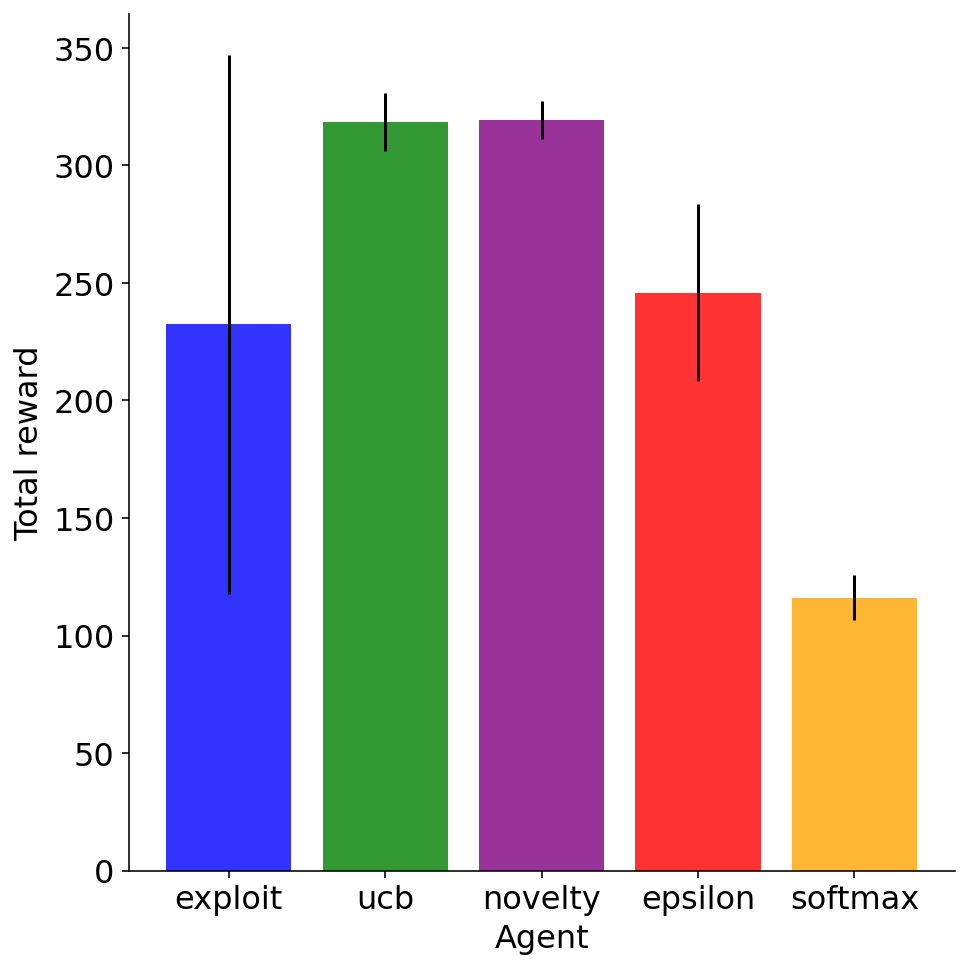

In [83]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

## Introducing a Deceptive Bandit

In the deceptive environment, the arm with the best long-term value appears to have decreasing value in the short term: the value of the arm decreases during the first 10 trials and then increases again during the next 10 trials.

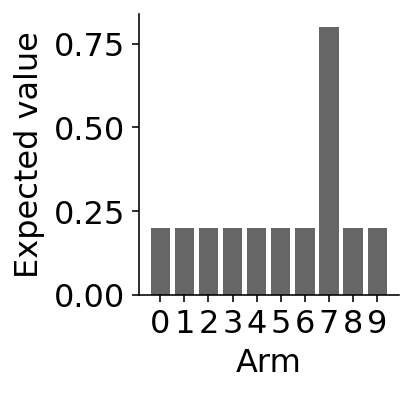

In [73]:
# Shared env params
seed = 503

# Create env
env = DeceptiveBanditOneHigh10()
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

In [74]:
exploit = BanditActorCritic(
    DeterministicActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
ucb = BanditActorCritic(
    DeterministicActor(num_actions=env.num_arms),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)
novelty = BanditActorCritic(
    DeterministicActor(num_actions=env.num_arms),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
egreedy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.2),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
softmax = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=1.0),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [exploit, ucb, novelty, egreedy, softmax]
names = ["exploit", "ucb", "novelty", "epsilon", "softmax"]
colors = ["blue", "green", "purple", "red", "orange", "yellow"]

In [75]:
num_steps = 400
num_experiments = 400

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

exploit:   0%|          | 0/400 [00:00<?, ?it/s]

ucb:   0%|          | 0/400 [00:00<?, ?it/s]

novelty:   0%|          | 0/400 [00:00<?, ?it/s]

epsilon:   0%|          | 0/400 [00:00<?, ?it/s]

softmax:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

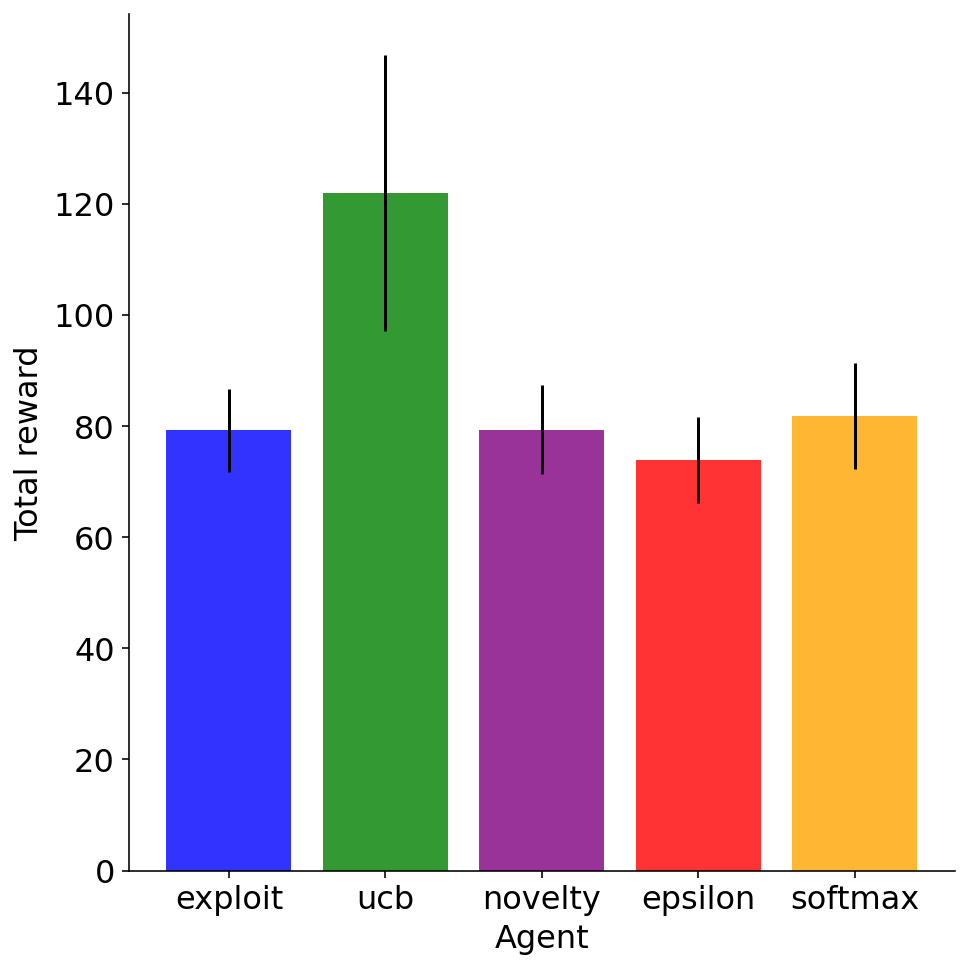

In [76]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

## Demonstration: Running a dual-value agent on a deceptive bandit using Infomercial


Infomercial (https://github.com/CoAxLab/infomercial) is a different python library for running bandit-style tasks. It is similar to explorationlib but has some different features, notably it supports "dual-value" agents, such as the one below, which seek to maximize both reward and information.

Infomercial is mainly designed to be run on the linux command line, I will be giving a demonstration of it.

In [ ]:
# don't run this cell
# meta_bandit.py

import os
import fire
import gym

import numpy as np

from noboard.csv import SummaryWriter

from copy import deepcopy
from scipy.stats import entropy
from collections import OrderedDict

from infomercial.models import Critic
from infomercial.models import DeterministicActor

from infomercial.memory import DiscreteDistribution
from infomercial.distance import kl
from infomercial.utils import estimate_regret
from infomercial.utils import load_checkpoint
from infomercial.utils import save_checkpoint


def R_update(state, reward, critic, lr):
    """Really simple TD learning"""

    update = lr * (reward - critic(state))
    critic.update(state, update)

    return critic


def E_update(state, value, critic, lr):
    """Bellman update"""
    update = lr * value
    critic.replace(state, update)

    return critic


def R_homeostasis(reward, total_reward, set_point):
    """Update reward value assuming homeostatic value.
    
    Value based on Keramati and Gutkin, 2014.
    https://elifesciences.org/articles/04811
    """
    deviance_last = np.abs(set_point - total_reward)
    deviance = np.abs(set_point - (total_reward + reward))
    reward_value = deviance_last - deviance
    return reward_value


def run(env_name='BanditOneHot10-v0',
        num_episodes=1000,
        tie_break='next',
        tie_threshold=0.0,
        lr_R=.1,
        master_seed=42,
        initial_bins=None,
        write_to_disk=True,
        load=None,
        log_dir=None):
    """Bandit agent - argmax (E, R)"""

    # --- Init ---
    writer = SummaryWriter(log_dir=log_dir, write_to_disk=write_to_disk)

    # -
    env = gym.make(env_name)
    env.seed(master_seed)
    env.reset()

    num_actions = env.action_space.n
    all_actions = list(range(num_actions))
    best_action = env.best

    default_reward_value = 0
    default_info_value = entropy(np.ones(num_actions) / num_actions)
    E_t = default_info_value
    R_t = default_reward_value

    # - Init agents and memories
    critic_R = Critic(num_actions, default_value=default_reward_value)
    critic_E = Critic(num_actions, default_value=default_info_value)
    actor_R = DeterministicActor(num_actions,
                                 tie_break='first',
                                 tie_threshold=tie_threshold)
    actor_E = DeterministicActor(num_actions,
                                 tie_break=tie_break,
                                 tie_threshold=tie_threshold)

    memories = [
        DiscreteDistribution(initial_bins=initial_bins)
        for _ in range(num_actions)
    ]

    # Update with pre-loaded data. This will let you run
    # test experiments on pre-trained model and/or to
    # continue training.
    if load is not None:
        result = load_checkpoint(load)
        critic_E.load_state_dict(result['critic_E'])
        critic_R.load_state_dict(result['critic_R'])
        for i, mem in enumerate(memories):
            mem.load_state_dict(result['memories'][i])

    # -
    num_best = 0
    total_R = 0.0
    total_E = 0.0
    total_regret = 0.0

    # ------------------------------------------------------------------------
    for n in range(num_episodes):
        env.reset()

        # Meta-greed policy selection
        if (E_t - tie_threshold) > R_t:
            critic = critic_E
            actor = actor_E
            policy = 0
        else:
            critic = critic_R
            actor = actor_R
            policy = 1

        # Choose an action; Choose a bandit
        action = actor(list(critic.model.values()))
        if action in best_action:
            num_best += 1

        # Est. regret and save it
        regret = estimate_regret(all_actions, action, critic)

        # Pull a lever.
        state, R_t, _, _ = env.step(action)
        R_t = R_homeostasis(R_t, total_R, num_episodes)

        # Estimate E
        old = deepcopy(memories[action])
        memories[action].update((int(state), int(R_t)))
        new = deepcopy(memories[action])
        E_t = kl(new, old, default_info_value)

        # Learning, both policies.
        critic_R = R_update(action, R_t, critic_R, lr_R)
        critic_E = E_update(action, E_t, critic_E, lr=1)

        # Log data
        writer.add_scalar("policy", policy, n)
        writer.add_scalar("state", state, n)
        writer.add_scalar("action", action, n)
        writer.add_scalar("regret", regret, n)
        writer.add_scalar("score_E", E_t, n)
        writer.add_scalar("score_R", R_t, n)
        writer.add_scalar("value_E", critic_E(action), n)
        writer.add_scalar("value_R", critic_R(action), n)

        total_E += E_t
        total_R += R_t
        total_regret += regret
        writer.add_scalar("total_regret", total_regret, n)
        writer.add_scalar("total_E", total_E, n)
        writer.add_scalar("total_R", total_R, n)
        writer.add_scalar("p_bests", num_best / (n + 1), n)

        tie = 0
        if actor.tied:
            tie = 1
        writer.add_scalar("ties", tie, n)

    # -- Build the final result, and save or return it ---
    writer.close()

    result = dict(best=env.best,
                  num_episodes=num_episodes,
                  tie_break=tie_break,
                  tie_threshold=tie_threshold,
                  critic_E=critic_E.state_dict(),
                  critic_R=critic_R.state_dict(),
                  memories=[m.state_dict() for m in memories],
                  total_E=total_E,
                  total_R=total_R,
                  total_regret=total_regret,
                  env_name=env_name,
                  lr_R=lr_R,
                  master_seed=master_seed)

    if write_to_disk:
        save_checkpoint(result,
                        filename=os.path.join(writer.log_dir, "result.pkl"))

    return result


if __name__ == "__main__":
    fire.Fire(run)